# garmin health data analysis (v2)

analyzing daily health metrics from garmin watch data stored in bigquery to understand what affects stress levels.

**data pipeline:**
- raw JSON files → BigQuery (`garmin_raw_data`)
- SQL views parse and clean data (`v_daily_metrics`)
- steps with 0 values automatically marked as NULL (no data collected)

In [ ]:
import os
from google.cloud import bigquery
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import json
from functools import reduce
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Path to credentials (relative to project root)
PROJECT_ROOT = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.join(PROJECT_ROOT, "spatiotemporal-key.json")

# Initialize BigQuery client
client = bigquery.Client()

In [ ]:
# Load clean daily metrics directly from BigQuery view
# Data quality (steps=0 → NULL) is handled in the SQL view

query = """
SELECT * FROM `garmin_data.v_daily_metrics`
ORDER BY date
"""
df = client.query(query).to_dataframe()

print(f"Loaded {len(df)} days of data")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nColumns: {list(df.columns)}")
df.head()

In [ ]:
# Data quality summary from BigQuery view
quality_query = """
SELECT * FROM `garmin_data.v_data_quality_summary`
ORDER BY month
"""
quality_df = client.query(quality_query).to_dataframe()
print("Data Quality by Month:")
print(quality_df.to_string(index=False))

In [ ]:
# Prepare data for analysis
# The SQL view already handles:
# - JSON parsing
# - Steps 0 → NULL conversion
# - Merging all metrics by date

# Select numeric columns for analysis (exclude flags and categories)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numeric columns available: {numeric_cols}")

# Check missing values
missing = df[numeric_cols].isna().sum()
missing_pct = (missing / len(df) * 100).round(1)
print(f"\nMissing values (%):")
for col, pct in missing_pct.items():
    if pct > 0:
        print(f"  {col}: {pct}%")

# dataset structure

the BigQuery views provide clean, structured data:
- `v_steps_daily` - daily step totals with quality flags
- `v_body_battery_daily` - charged/drained metrics
- `v_heart_rate_daily` - resting HR, min/max HR
- `v_stress_daily` - avg/max stress with categories
- `v_sleep_daily` - sleep hours, HRV, body battery change
- `v_daily_metrics` - merged daily view (used here)
- `v_data_quality_summary` - monthly coverage stats

In [ ]:
# Available columns from the view
print("Columns in v_daily_metrics:")
for col in df.columns:
    dtype = df[col].dtype
    non_null = df[col].notna().sum()
    print(f"  {col:30} {str(dtype):15} ({non_null}/{len(df)} non-null)")

# data preparation

all merging and JSON parsing is now done in BigQuery views. we just need to:
1. select features for analysis
2. handle remaining missing values

In [ ]:
# Select key features for analysis
# Steps has ~56% missing (Feb-Aug 2025), so we'll exclude it or use subset

feature_cols = [
    'charged', 'drained', 'net_battery',
    'resting_hr', 'avg_resting_hr_7d',
    'avg_stress', 'max_stress',
    'sleep_hours', 'deep_sleep_hours', 'rem_sleep_hours',
    'sleep_body_battery_change', 'avg_overnight_hrv'
]

# Filter to existing columns
feature_cols = [c for c in feature_cols if c in df.columns]
print(f"Features for analysis: {feature_cols}")

# Create analysis dataframe
merged_daily_agg = df[['date'] + feature_cols + ['steps', 'has_steps_data']].copy()

# Rename for consistency with existing analysis code
merged_daily_agg = merged_daily_agg.rename(columns={
    'avg_stress': 'avgStressLevel',
    'max_stress': 'maxStressLevel', 
    'resting_hr': 'restingHeartRate',
    'sleep_body_battery_change': 'bodyBatteryChange'
})

print(f"\nDataset shape: {merged_daily_agg.shape}")
merged_daily_agg.head()

In [ ]:
# Data quality check
# Steps are already NULL for days with no data (handled in BigQuery view)

rows_total = len(merged_daily_agg)
missing_steps = merged_daily_agg['steps'].isna().sum()

print(f"Total days: {rows_total}")
print(f"Days with steps data: {rows_total - missing_steps}")
print(f"Days without steps data: {missing_steps} (Feb-Aug 2025 - watch not tracking)")
print(f"\nData quality flag from BigQuery: {merged_daily_agg['has_steps_data'].value_counts().to_dict()}")

# cleaning

handling missing values and filtering out bad data.

## missing values

checking which columns have too many missing values.

In [ ]:
# Missing values check
missing_ratio = merged_daily_agg.isna().mean() * 100
missing_over_50 = missing_ratio[missing_ratio > 50].sort_values(ascending=False)

print("=== Columns with >50% Missing Values ===")
if missing_over_50.empty:
    print("No columns have more than 50% missing values.")
else:
    for col, pct in missing_over_50.items():
        print(f"  {col}: {pct:.1f}%")

## dropping and filling

dropping columns with more than 50% missing, filling the rest with median.

In [ ]:
# Handle missing values
# Drop columns with >50% missing, fill rest with median

missing_ratio = merged_daily_agg.isna().mean() * 100
cols_to_drop = missing_ratio[missing_ratio > 50].index.tolist()

# Keep track of what we're dropping
if cols_to_drop:
    print(f"Dropping columns with >50% missing: {cols_to_drop}")
    merged_daily_agg = merged_daily_agg.drop(columns=cols_to_drop)

# Fill remaining numeric columns with median
for col in merged_daily_agg.select_dtypes(include=np.number).columns:
    if merged_daily_agg[col].isna().any():
        median_val = merged_daily_agg[col].median()
        merged_daily_agg[col] = merged_daily_agg[col].fillna(median_val)

print(f"\nFinal shape: {merged_daily_agg.shape}")
print(f"Remaining missing values: {merged_daily_agg.isna().sum().sum()}")

## final dataset

In [10]:
print("=== Columns and Data Types ===")
for col, dtype in merged_daily_agg.dtypes.items():
    print(f"{col:40}  {dtype}")


=== Columns and Data Types ===
date                                      datetime64[ns]
bodyBatteryChange                         float64
charged                                   int64
drained                                   int64
restingHeartRate                          int64
lastSevenDaysAvgRestingHeartRate          int64
maxStressLevel                            int64
avgStressLevel                            int64
primaryActivityLevel                      object
activityLevelConstant                     bool


In [11]:
# === Data Summary ===
print("=" * 50)
print("DATASET SUMMARY")
print("=" * 50)
print(f"Date Range: {merged_daily_agg['date'].min().strftime('%Y-%m-%d')} to {merged_daily_agg['date'].max().strftime('%Y-%m-%d')}")
print(f"Total Days: {len(merged_daily_agg)}")
print(f"Features: {merged_daily_agg.shape[1] - 1} (excluding date)")
print()
print("Key Metrics (Mean ± Std):")

# Print available metrics dynamically
key_metrics = {
    'avgStressLevel': 'Avg Stress Level',
    'restingHeartRate': 'Resting Heart Rate', 
    'steps': 'Daily Steps',
    'bodyBatteryChange': 'Body Battery Change',
    'avgOvernightHrv': 'Overnight HRV',
    'heartRateValues_mean': 'Heart Rate (mean)'
}

for col, label in key_metrics.items():
    if col in merged_daily_agg.columns:
        mean_val = merged_daily_agg[col].mean()
        std_val = merged_daily_agg[col].std()
        if col == 'steps':
            print(f"  - {label}: {mean_val:,.0f} ± {std_val:,.0f}")
        else:
            print(f"  - {label}: {mean_val:.1f} ± {std_val:.1f}")

print("=" * 50)

DATASET SUMMARY
Date Range: 2025-02-25 to 2026-01-25
Total Days: 335
Features: 9 (excluding date)

Key Metrics (Mean ± Std):
  - Avg Stress Level: 40.9 ± 8.2
  - Resting Heart Rate: 60.7 ± 3.6
  - Body Battery Change: 53.6 ± 19.2


# exploratory analysis

looking at how features relate to stress levels and running pca to find underlying patterns.

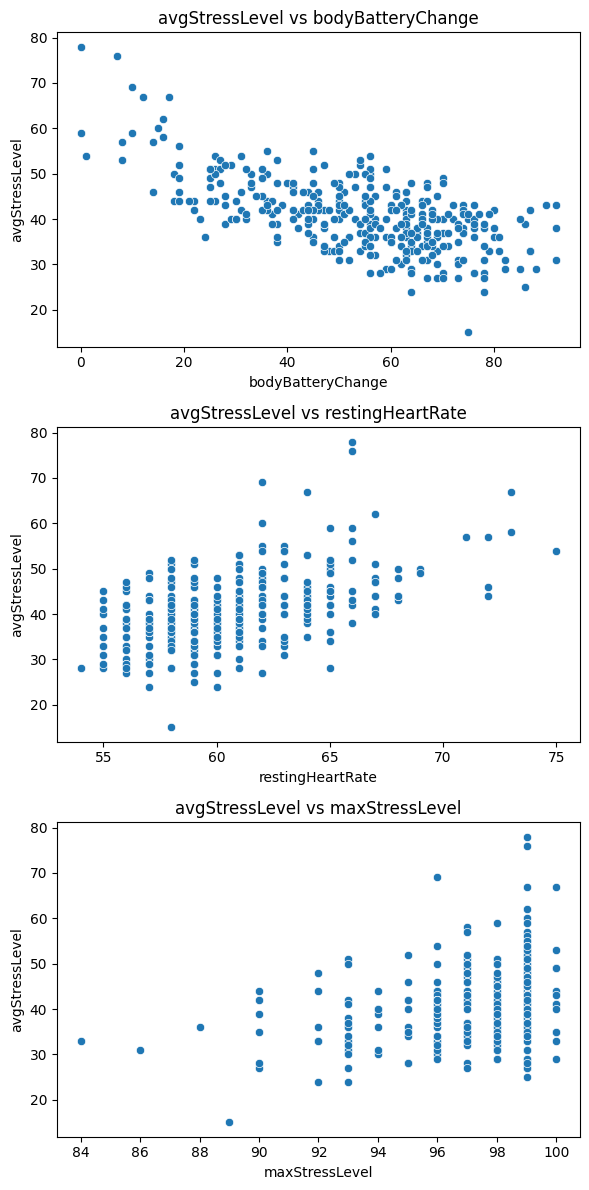

In [12]:
# Define x variables - filter to only those that exist in the dataframe
x_vars_all = [
    'sleepHeartRate_mean', 
    'sleepStress_mean', 
    'steps', 
    'bodyBatteryChange', 
    'restingHeartRate', 
    'heartRateValues_mean', 
    'maxStressLevel',
    'sleepRestlessMoments_mean'
]

# Filter to only columns that exist
x_vars = [x for x in x_vars_all if x in merged_daily_agg.columns]

if len(x_vars) == 0:
    print("No matching variables found for scatter plots")
else:
    # Create a figure
    fig, axes = plt.subplots(len(x_vars), 1, figsize=(6, 4 * len(x_vars)))
    
    # Handle single subplot case
    if len(x_vars) == 1:
        axes = [axes]

    # Plot each scatter plot
    for i, x in enumerate(x_vars):
        sns.scatterplot(data=merged_daily_agg, x=x, y='avgStressLevel', ax=axes[i])
        axes[i].set_title(f'avgStressLevel vs {x}')
        axes[i].set_xlabel(x)
        axes[i].set_ylabel('avgStressLevel')

    plt.tight_layout()
    plt.show()

body battery change has a negative correlation with stress - better recovery means lower stress. max stress level obviously correlates with average stress. steps don't show a strong relationship.


Analyzing 6 numeric features...

--- Explained Variance Ratio ---
PC 1: 59.14% variance explained (Cumulative: 59.14%)
PC 2: 17.32% variance explained (Cumulative: 76.46%)
PC 3: 14.52% variance explained (Cumulative: 90.98%)
PC 4: 4.21% variance explained (Cumulative: 95.19%)
PC 5: 3.14% variance explained (Cumulative: 98.33%)
...


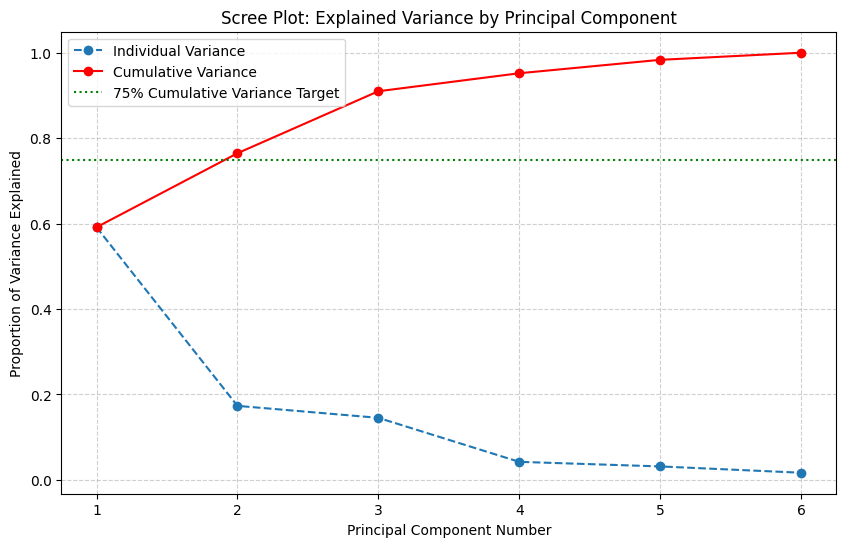


--- Component Loadings (Focus on PC1 and PC2) ---
Interpretation Key:
 - A large POSITIVE loading means the feature contributes heavily to the PC in a positive direction.
 - A large NEGATIVE loading means the feature contributes heavily to the PC in a negative direction.
 - Values near 0 mean the feature has little influence on that PC.
--------------------------------------------------
                                   PC 1   PC 2
charged                           0.481 -0.169
bodyBatteryChange                 0.480 -0.170
drained                           0.478  0.076
maxStressLevel                    0.056  0.938
lastSevenDaysAvgRestingHeartRate -0.278 -0.239
restingHeartRate                 -0.479 -0.017


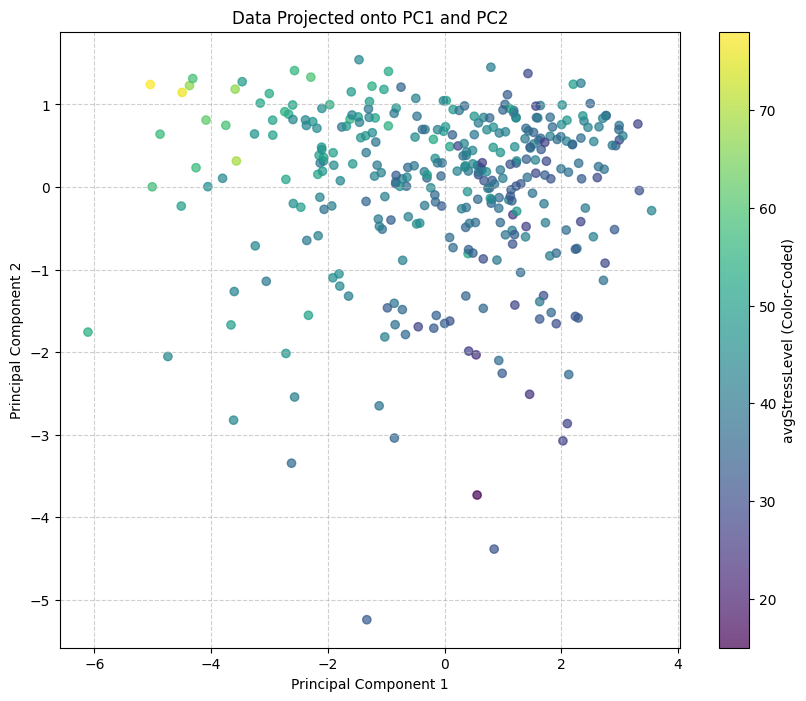

In [13]:
# --- 2. DATA PREPARATION ---

# Separate the potential response variable (Y) from the predictors (X)
Y = merged_daily_agg['avgStressLevel']

# The TypeError indicates non-numeric columns (like Date/ID) are present.
# We explicitly select only numeric columns for PCA and standardization.
# We also drop the target variable 'avgStressLevel'.
X = merged_daily_agg.drop(columns=['avgStressLevel'], errors='ignore')
X = X.select_dtypes(include=np.number)
feature_names = X.columns

print(f"\nAnalyzing {len(feature_names)} numeric features...")

# Standardize the features (Mean=0, StdDev=1)
# This is crucial for PCA as it's sensitive to scale.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 3. APPLY PCA ---

# Instantiate PCA (using None means we keep all components initially)
pca = PCA(n_components=None)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

# --- 4. EXPLAINED VARIANCE (SCREE PLOT) ---

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print("\n--- Explained Variance Ratio ---")
for i, (evr, cv) in enumerate(zip(explained_variance_ratio[:5], cumulative_variance[:5])):
    print(f"PC {i+1}: {evr*100:.2f}% variance explained (Cumulative: {cv*100:.2f}%)")
print("...")

# Plotting the Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', label='Individual Variance')
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='-', color='red', label='Cumulative Variance')
plt.title('Scree Plot: Explained Variance by Principal Component')
plt.xlabel('Principal Component Number')
plt.ylabel('Proportion of Variance Explained')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(y=0.75, color='green', linestyle=':', label='75% Cumulative Variance Target')
plt.legend()
plt.show() # 

# --- 5. INTERPRETATION: FEATURE LOADINGS ---

# Create a DataFrame for easier inspection of loadings
# The loadings (or components) show how much each original feature contributes to the new PC.
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC {i+1}' for i in range(X_pca.shape[1])],
    index=feature_names
)

print("\n--- Component Loadings (Focus on PC1 and PC2) ---")
print("Interpretation Key:")
print(" - A large POSITIVE loading means the feature contributes heavily to the PC in a positive direction.")
print(" - A large NEGATIVE loading means the feature contributes heavily to the PC in a negative direction.")
print(" - Values near 0 mean the feature has little influence on that PC.")
print("-" * 50)

# Display the top features driving the first two principal components
# We use .round(3) for cleaner output.
print(loadings[['PC 1', 'PC 2']].sort_values(by='PC 1', ascending=False).round(3))

# --- 6. OPTIONAL: VISUALIZING THE DATA IN 2D ---

# Scatter plot of the first two components
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y, cmap='viridis', alpha=0.7)
plt.colorbar(label='avgStressLevel (Color-Coded)')
plt.title('Data Projected onto PC1 and PC2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show() # 



## pca results

pc1 captures the "strain vs recovery" pattern - it's the main factor that explains stress. high pc1 means high stress, low pc1 means good recovery.

# models

training random forest for regression and logistic regression for classification.

In [ ]:
import sys
import os

# Add notebook directory to path (relative to current file)
notebook_dir = os.path.dirname(os.path.abspath(__file__))
sys.path.append(notebook_dir)

# Load your algorithm script
import importlib
import algorithms  # assuming the file is algorithms.py
from algorithms import logistic_reg

importlib.reload(algorithms)

## random forest

predicting continuous stress values.

Fitting 3 folds for each of 108 candidates, totalling 324 fits


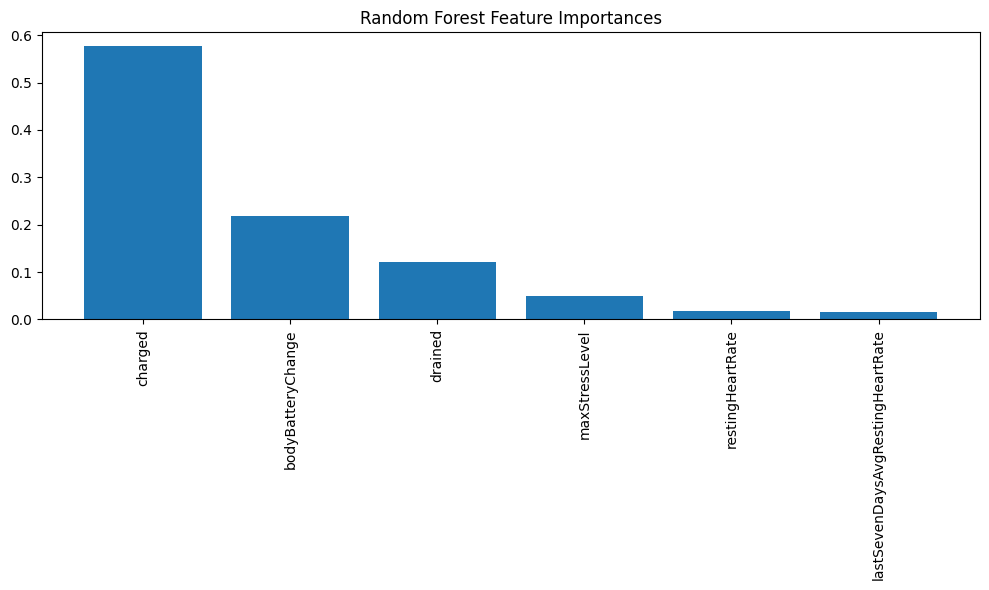

Best RF Params: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
{'r2': 0.4825955127695384, 'rmse': np.float64(5.3874338818023695), 'mae': 4.259768975033429}


In [15]:
# Features
target = 'avgStressLevel'
features = merged_daily_agg.select_dtypes(include=['int64','float64']).columns.tolist()
features = [f for f in features if f != target]

# Random Forest
rf_results = algorithms.train_random_forest(merged_daily_agg, target, features)
print(rf_results['metrics'])

feature importance shows which metrics matter most for predicting stress.

## logistic regression

classifying days as high stress (>50) or normal (<=50).

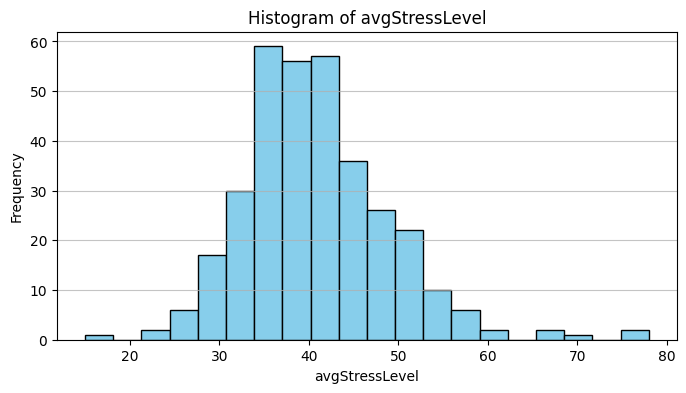

In [16]:
# Assuming merged_daily_agg is already loaded
plt.figure(figsize=(8,4))
plt.hist(merged_daily_agg['avgStressLevel'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of avgStressLevel')
plt.xlabel('avgStressLevel')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


garmin stress scale: 0-25 resting, 26-50 low, 51-75 medium, 76-100 high. using 50 as the cutoff for "high stress" classification.

features: ['bodyBatteryChange', 'restingHeartRate', 'charged', 'drained', 'maxStressLevel']
high stress days: 37 / 335

logistic regression results
train accuracy: 0.929
test accuracy: 0.925

coefficients:
          feature  coefficient  odds_ratio
          charged    -0.819903    0.440474
bodyBatteryChange    -0.562722    0.569656
   maxStressLevel     0.463652    1.589870
          drained    -0.181579    0.833952
 restingHeartRate     0.055692    1.057272


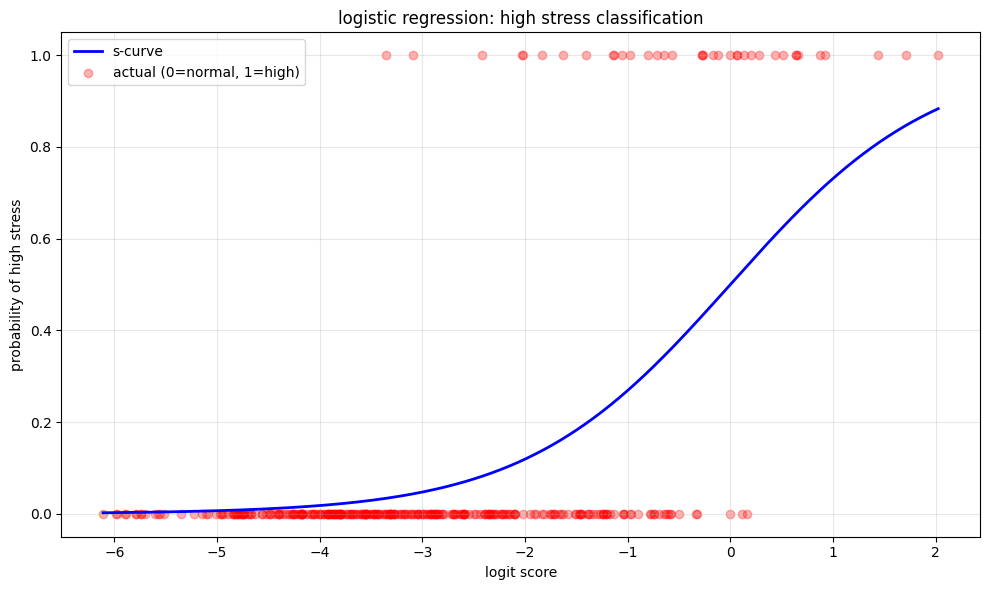

In [17]:
# create binary target: high stress (>50) vs normal (<=50)
merged_daily_agg['high_stress'] = (merged_daily_agg['avgStressLevel'] > 50).astype(int)

# select features - use fewer, more interpretable features to avoid overfitting
core_features = ['bodyBatteryChange', 'restingHeartRate', 'charged', 'drained', 'maxStressLevel']
log_features = [f for f in core_features if f in merged_daily_agg.columns]

print(f"features: {log_features}")
print(f"high stress days: {merged_daily_agg['high_stress'].sum()} / {len(merged_daily_agg)}")

# prepare data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

X = merged_daily_agg[log_features].copy()
y = merged_daily_agg['high_stress'].copy()

# train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train logistic regression with regularization
model = LogisticRegression(max_iter=1000, C=0.1)  # C=0.1 adds regularization
model.fit(X_train_scaled, y_train)

# evaluate
train_acc = model.score(X_train_scaled, y_train)
test_acc = model.score(X_test_scaled, y_test)

print(f"\n{'='*50}")
print("logistic regression results")
print(f"{'='*50}")
print(f"train accuracy: {train_acc:.3f}")
print(f"test accuracy: {test_acc:.3f}")

# coefficients
summary = pd.DataFrame({
    "feature": log_features,
    "coefficient": model.coef_[0],
    "odds_ratio": np.exp(model.coef_[0])
}).sort_values('coefficient', key=abs, ascending=False)

print(f"\ncoefficients:")
print(summary.to_string(index=False))

# plot s-curve using training data
X_all_scaled = scaler.transform(X)
logit = model.intercept_[0] + np.dot(X_all_scaled, model.coef_[0])

plt.figure(figsize=(10, 6))
logit_range = np.linspace(logit.min(), logit.max(), 500)
prob_range = 1 / (1 + np.exp(-logit_range))

plt.plot(logit_range, prob_range, color='blue', lw=2, label='s-curve')
plt.scatter(logit, y, color='red', alpha=0.3, label='actual (0=normal, 1=high)')
plt.xlabel("logit score")
plt.ylabel("probability of high stress")
plt.title("logistic regression: high stress classification")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### results

- positive coefficient = increases odds of high stress
- negative coefficient = decreases odds (protective)
- odds ratio > 1 = risk factor
- odds ratio < 1 = protective factor

the s-curve shows how the model maps the combined score to probability of high stress.

# summary

## data pipeline
- raw JSON files fetched from Garmin API → stored locally
- `load_to_bigquery.py` → uploads to `garmin_data.garmin_raw_data`
- `deploy_views.py` → creates SQL views that parse JSON and handle data quality
- `v_daily_metrics` → clean, analysis-ready daily data

## data quality
- steps data only available from sep 2025 (watch not tracking earlier)
- SQL view automatically marks steps=0 as NULL
- other metrics (body battery, stress, heart rate, sleep) complete for all 335 days

## findings
- pca shows recovery vs strain is the main pattern driving stress
- random forest: body battery and resting heart rate are strongest predictors
- logistic regression: body battery change is the key protective factor

## to refresh data
```bash
python garmin/parse_garmin.py     # fetch new data from Garmin
python garmin/load_to_bigquery.py # upload to BigQuery
python garmin/deploy_views.py     # refresh views
```